In [1]:
import pandas as pd
from get_SAB import *
import copy
import numpy as np 
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
import matplotlib

In [2]:

info2 = {}
maxSAB = 0.0
with open('leaprRun/tape24','r') as f:
    lines = [line for line in f.readlines() if line[71:75] == '7  4']

    nbeta  = getVal(lines[4],5,'int')
    nalpha = getVal(lines[6],5,'int')
    numAlphaLines = ceil(nalpha/3)
    lines = lines[6:]

    for ibeta in range(nbeta):
        offset = 2
        beta = getVal(lines[0],1)
        alphas, sab = [], []
        for i in range(numAlphaLines):
            for j in range(3):
                alphas.append(getVal(lines[offset+i],2*j  ))
                sabVal = getVal(lines[offset+i],2*j+1)
                #sabVal = np.log(sabVal) if sabVal > 1e-9 else -20
                sab.append(sabVal)
                if sab[-1] > maxSAB:
                    maxSAB = sab[-1]
        info2[beta]  = [val*np.exp(-beta*0.5) for val in sab]
        info2[-beta] = [val*np.exp( beta*0.5) for val in sab]
        #info2[beta]  = [val*np.exp(-beta) for val in sab]
        #info2[-beta] = [val*np.exp(0.0)   for val in sab]
        lines = lines[numAlphaLines+offset:]

    betas = (list(info2.keys()))
    betas.sort()


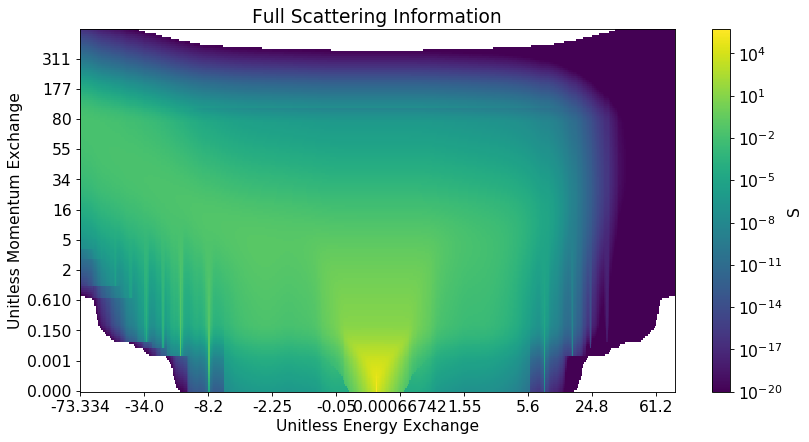

In [3]:
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
matplotlib.rcParams.update({'font.size': 14})
df = pd.DataFrame(data=info2)
df = df.sort_index(ascending = True, axis = 1)

df2 = pd.DataFrame(data=info2, index=alphas,columns=betas)
df2 = df2.sort_index(ascending = True, axis = 1)




plt.pcolor(df, norm=LogNorm(vmin=1e-20, vmax=maxSAB))#, cmap='PuBu_r')
# plt.pcolor(df2, vmin=-20, vmax=13)#, cmap='PuBu_r')
plt.colorbar(label='S')
plt.yticks(np.arange(0.5, len(df2.index), 15), ['%.3f'%x if x < 1 else '%.0f'%x for x in df2.index[::15] ])
plt.xticks(np.arange(0.5, len(df2.columns), 50), df2.columns[::50])
plt.xlabel('Unitless Energy Exchange')
plt.ylabel('Unitless Momentum Exchange')
plt.title('Full Scattering Information')
plt.show()

In [4]:
E = 1.0
kbT = 0.025
betaMin = -E/kbT
betaMax = 20.0
A = 1.0

In [5]:
eq14 = []
eq15 = []
this_df = df2

for ibeta,beta in enumerate(betas):
    alphaMin = ((E)**0.5-(E+beta*kbT)**0.5)**2 / (A*kbT)
    alphaMax = ((E)**0.5+(E+beta*kbT)**0.5)**2 / (A*kbT)
    df_subset = this_df[beta].loc[(this_df.index > alphaMin) & (this_df.index < alphaMax)]
    these_alphas = list(df_subset.index)
    eq14.append(np.trapz(df_subset,x=these_alphas))

total = np.trapz(eq14,x=betas)

eq14 = [val/total for val in eq14]

Text(0.5, 1.0, 'S(a,b) Beta PDF [Eq. 14]')

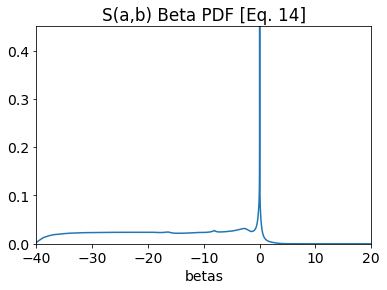

In [6]:
plt.plot(betas,eq14)
plt.xlim([betaMin,betaMax])
plt.ylim([0,0.45])
plt.xlabel('betas')
plt.title('S(a,b) Beta PDF [Eq. 14]')

Text(0.5, 1.0, 'S(a,b) Beta CDF [Eq. 16]')

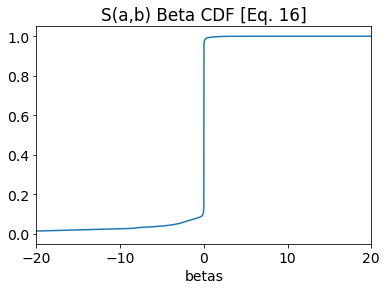

In [7]:
eq16 = np.cumsum(eq14)
total = eq16[-1]
eq16 = [val/total for val in eq16]
plt.plot(betas,eq16)
plt.xlim([-20,20])
plt.xlabel('betas')
plt.title('S(a,b) Beta CDF [Eq. 16]')

Text(0.5, 1.0, 'S(a,b) Alpha PDF [Eq. 15]')

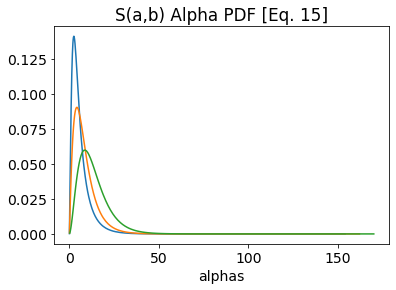

In [8]:

for ibeta in [280,300,350]:
    beta = betas[ibeta]
    alphaMin = ((E)**0.5-(E+beta*kbT)**0.5)**2 / (A*kbT)
    alphaMax = ((E)**0.5+(E+beta*kbT)**0.5)**2 / (A*kbT)

    eq15 = []

    df_subset    = this_df[beta].loc[(this_df.index > alphaMin) & (this_df.index < alphaMax)]
    these_alphas = list(df_subset.index)
    denominator  = np.trapz(df_subset,x=these_alphas)

    for alpha in these_alphas:
        eq15.append(df_subset[alpha]/denominator)

    plt.plot(these_alphas,eq15) 
plt.xlabel('alphas')
plt.title('S(a,b) Alpha PDF [Eq. 15]')

In [9]:
data = pd.DataFrame(columns=betas,index=alphas)
for beta in betas:
    data[beta] = 0.0

maxVal = 0.0
for ibeta in range(len(betas)):
    beta = betas[ibeta]
    alphaMin = ((E)**0.5-(E+beta*kbT)**0.5)**2 / (A*kbT)
    alphaMax = ((E)**0.5+(E+beta*kbT)**0.5)**2 / (A*kbT)
    eq15 = []

    df_subset    = this_df[beta].loc[(this_df.index > alphaMin) & (this_df.index < alphaMax)]
    these_alphas = list(df_subset.index)
    denominator  = np.trapz(df_subset,x=these_alphas)

    for alpha in these_alphas:
        eq15.append(df_subset[alpha]/denominator)
        data[beta].loc[alpha] = eq15[-1]
        if maxVal < eq15[-1]:
            maxVal = eq15[-1]

        

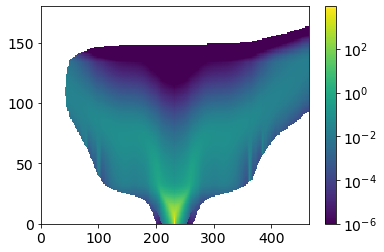

In [10]:
# plt.pcolor(data)
plt.pcolor(data, norm=LogNorm(vmin=1e-6, vmax=maxVal))
plt.colorbar()

In [30]:
# U, sigma, V = np.linalg.svd(data)
# norms = []
# numEigenvals = 10
# figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
# matplotlib.rcParams.update({'font.size': 14})
# A_approx = np.matrix(U[:, :numEigenvals]) * np.diag(sigma[:numEigenvals]) * np.matrix(V[:numEigenvals, :])
# A_approx_df = pd.DataFrame(A_approx)
# plt.pcolor(A_approx_df, norm=LogNorm(vmin=1e-6, vmax=maxVal))
# plt.colorbar(label='Log[S]')
# plt.yticks(np.arange(0.5, len(data.index), 15), ['%.3f'%x if x < 1 else '%.1f'%x for x in data.index[::15] ])
# plt.xticks(np.arange(0.5, len(data.columns), 35), data.columns[::35])
# plt.xlabel('Unitless Energy Exchange')
# plt.ylabel('Unitless Momentum Exchange')
# plt.title(str(numEigenvals)+' Singular Values')
# plt.show()

In [31]:
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

# plt.plot(sigma[:20],'ro-')
# plt.ylabel('Singular Values')
# plt.xlabel('Index')
# plt.title(r'Singular Values of S($\alpha,\beta$)')